In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

In [52]:
lob_data= pd.read_csv("C:/Users/keert/OneDrive/Desktop/Mini Project/resampled_lob_secs2.csv")
lob_data['Datetime'] = pd.to_datetime(lob_data['Datetime'])

lob_data['price']=(lob_data['Max Bid Price']*lob_data['Max Bid Quantity']+lob_data['Min Ask Price']*lob_data['Min Ask Quantity'])/(lob_data['Max Bid Quantity']+lob_data['Min Ask Quantity'])
# lob_data
lob_data

,Datetime,Min Ask Price,Max Bid Price,price,Total Bid Quantity,Total Ask Quantity,Min Ask Quantity,Max Bid Quantity,ofi,RSI,MA,Momentum
0,2025-01-02 00:00:02,310,261,293.666667,7,7,4,2,6,NaN,NaN,NaN
1,2025-01-02 00:00:03,293,262,269.750000,7,13,2,6,8,NaN,NaN,NaN
2,2025-01-02 00:00:04,287,264,271.666667,7,14,3,6,9,NaN,NaN,NaN
3,2025-01-02 00:00:05,283,264,272.636364,9,14,5,6,5,NaN,NaN,NaN
4,2025-01-02 00:00:06,281,265,267.285714,18,16,1,6,7,8.976775,275.001082,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3767279,2025-07-01 08:17:55,183,109,133.666667,21,18,1,2,-1,79.558011,124.390476,35.666667
3767280,2025-07-01 08:17:56,183,110,128.250000,24,18,1,3,3,81.702128,131.840476,37.250000
3767281,2025-07-01 08:17:57,123,110,114.333333,26,18,1,2,0,34.012739,129.450000,-11.952381
3767282,2025-07-01 08:17:58,114,109,111.500000,25,19,1,1,0,20.289855,125.350000,-20.500000


In [3]:
# ofi
def calculate_ofi(df):
    df['delta_bid'] = df['Max Bid Price'].diff().fillna(0)
    df['delta_ask'] = df['Min Ask Price'].diff().fillna(0)
    
        
    df['delta_w'] = df.apply(
        lambda row: row['Max Bid Quantity'] if row['delta_bid'] > 0 else
                   (-row['Max Bid Quantity'] if row['delta_bid'] < 0 else
                    row['Max Bid Quantity'] - df.loc[df.index[df.index.get_loc(row.name)-1], 'Max Bid Quantity']
                    if row.name > 0 else 0),
        axis=1)
    
    
    df['delta_v'] = df.apply(
        lambda row: -row['Min Ask Quantity'] if row['delta_ask'] > 0 else
                   (row['Min Ask Quantity'] if row['delta_ask'] < 0 else
                    row['Min Ask Quantity'] - df.loc[df.index[df.index.get_loc(row.name)-1], 'Min Ask Quantity']
                    if row.name > 0 else 0),
        axis=1)
    
    
    df['ofi'] = df['delta_w'] + df['delta_v']
    
    return df['ofi']

calculate_ofi(lob_data)
lob_data=lob_data[['Datetime','Min Ask Price','Max Bid Price','price','Total Bid Quantity','Total Ask Quantity','Min Ask Quantity','Max Bid Quantity','ofi']]
# drop the first row (ofi is 0)
lob_data = lob_data.iloc[1:]

In [4]:
def calculate_rsi(data, window):
    
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

lob_data['RSI'] = calculate_rsi(lob_data['price'], window=5) # calculate RSI
lob_data['MA'] = lob_data['price'].rolling(window=5).mean() # Cclculate moving avg
lob_data['Momentum'] = lob_data['price'] - lob_data['price'].shift(5) # Calculate momentum
# lob_data.head()

In [5]:
# This is only for trading volume, not for modeling

rolling_window = 5  
lob_data['Log Return Max Bid'] = np.log(lob_data['Max Bid Price'] / lob_data['Max Bid Price'].shift(1))
lob_data['Log Return Min Ask'] = np.log(lob_data['Min Ask Price'] / lob_data['Min Ask Price'].shift(1))


lob_data['Volatility Max Bid'] = lob_data['Log Return Max Bid'].rolling(window=rolling_window).std()
lob_data['Volatility Min Ask'] = lob_data['Log Return Min Ask'].rolling(window=rolling_window).std()


# Trading volume
def adjust_trade_quantity(volatility, max_tradeable_quantity, base_quantity=1, risk_tolerance=0.5, scaler_fator=10):
    
    adjusted_quantity = base_quantity / (volatility*risk_tolerance*scaler_fator)
    adjusted_quantity = max(1, round(adjusted_quantity))  
    final_trade_quantity = min(adjusted_quantity, max_tradeable_quantity)

    return final_trade_quantity

In [6]:
# split data
lob_data.columns

Index(['Datetime', 'Min Ask Price', 'Max Bid Price', 'price',
       'Total Bid Quantity', 'Total Ask Quantity', 'Min Ask Quantity',
       'Max Bid Quantity', 'ofi', 'RSI', 'MA', 'Momentum',
       'Log Return Max Bid', 'Log Return Min Ask', 'Volatility Max Bid',
       'Volatility Min Ask'],
      dtype='object')

In [54]:
import pandas as pd

# Remove rows where any of the columns have NaN values
lob_data = lob_data.dropna()

#print cleaned DataFrame
print(lob_data)


                   Datetime  Min Ask Price  Max Bid Price       price  \
5       2025-01-02 00:00:07            279            266  267.857143   
6       2025-01-02 00:00:08            276            266  268.500000   
7       2025-01-02 00:00:09            271            266  266.714286   
8       2025-01-02 00:00:10            269            267  267.333333   
9       2025-01-02 00:00:11            270            267  268.714286   
...                     ...            ...            ...         ...   
3767279 2025-07-01 08:17:55            183            109  133.666667   
3767280 2025-07-01 08:17:56            183            110  128.250000   
3767281 2025-07-01 08:17:57            123            110  114.333333   
3767282 2025-07-01 08:17:58            114            109  111.500000   
3767283 2025-07-01 08:17:59            112            108  110.000000   

         Total Bid Quantity  Total Ask Quantity  Min Ask Quantity  \
5                        18                  16       

In [89]:
import warnings
warnings.filterwarnings('ignore') 

In [90]:
# Prepare the target column for future prices
lob_data['future_price'] = lob_data['price'].shift(-1)
lob_data.dropna(inplace=True)  # Drop the last row with NaN 'future_price'

# Split the data while respecting the time series nature (no random split)
split_index = int(0.8 * len(lob_data))
train_data = lob_data[:split_index]
test_data = lob_data[split_index:]

# Select features
features = [col for col in lob_data.columns if col not in ['Datetime', 'Min Ask Price', 'Max Bid Price', 'future_price']]
X_train = train_data[features]
y_train = train_data['future_price']
X_test = test_data[features]
y_test = test_data['future_price']

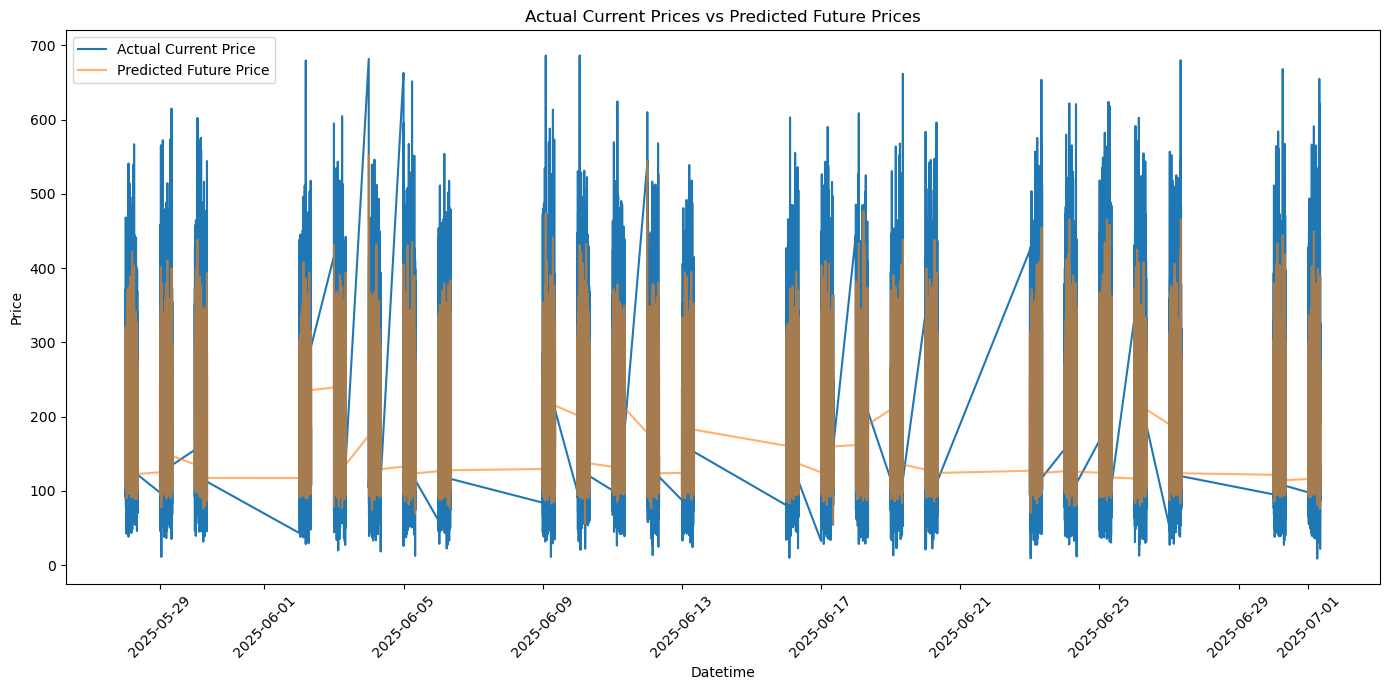

In [77]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model
model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Generate predictions
predictions = model.predict(X_test_scaled)

# Set the figure size for better visibility
plt.figure(figsize=(14, 7))

# Plot the actual current prices from the test data
plt.plot(test_data['Datetime'], test_data['price'], label='Actual Current Price')

plt.plot(test_data['Datetime'].iloc[1:], predictions[:-1], label='Predicted Future Price', alpha=0.6)

# Adding titles and labels
plt.title('Actual Current Prices vs Predicted Future Prices')
plt.xlabel('Datetime')
plt.ylabel('Price')
plt.legend()

# To improve the readability of the x-axis dates
plt.xticks(rotation=45)

# Ensure that everything fits without overlapping
plt.tight_layout()

# Display the plot
plt.show()


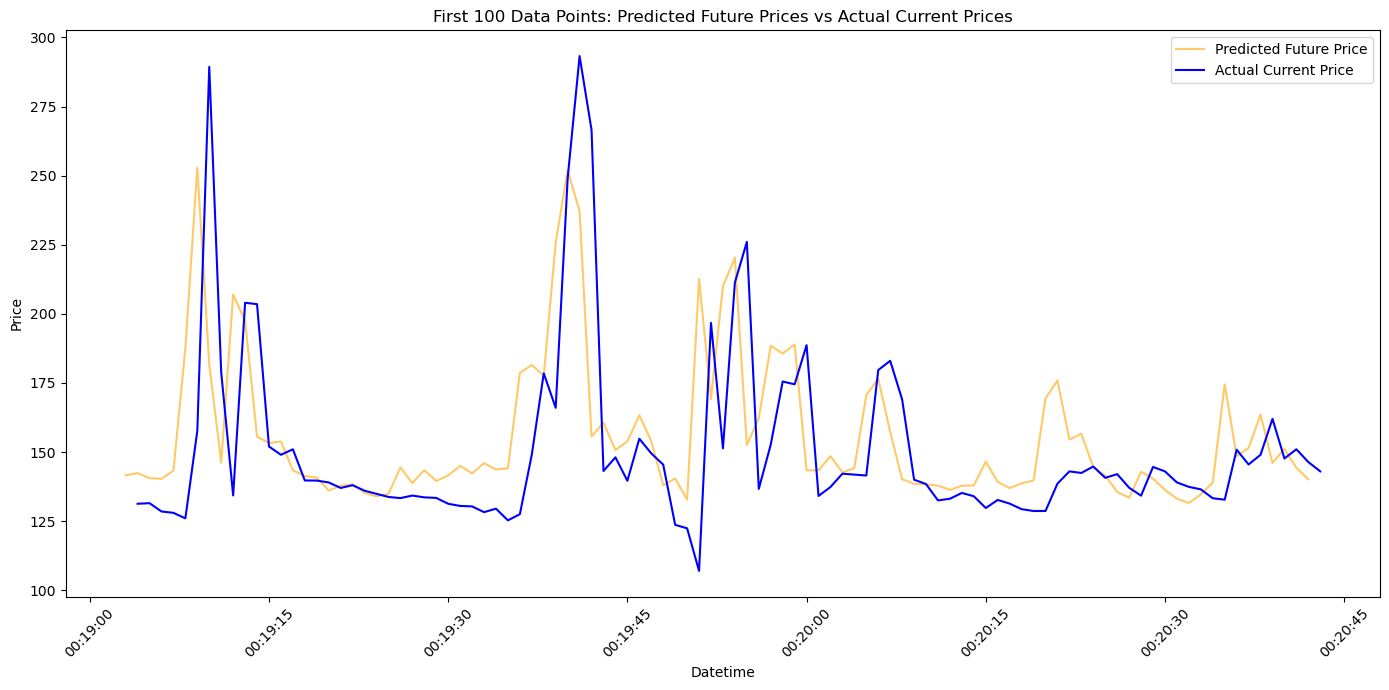

In [78]:
import matplotlib.pyplot as plt

# Assuming 'test_data' contains the datetime and actual price
# and 'predictions' contains the predicted future prices

# Set the figure size for better visibility
plt.figure(figsize=(14, 7))

# Plot the predicted future prices and specify the color orange
plt.plot(test_data['Datetime'].iloc[:100], predictions[:100], label='Predicted Future Price', color='orange', alpha=0.6)

# Plot the actual current prices and specify the color blue
plt.plot(test_data['Datetime'].iloc[1:101], test_data['price'].iloc[:100], label='Actual Current Price', color='blue')

# Adding titles and labels
plt.title('First 100 Data Points: Predicted Future Prices vs Actual Current Prices')
plt.xlabel('Datetime')
plt.ylabel('Price')
plt.legend()

# To improve the readability of the x-axis dates
plt.xticks(rotation=45)

# Ensure that everything fits without overlapping
plt.tight_layout()

# Display the plot
plt.show()


In [79]:
# Evaluation Metrics
mae = mean_absolute_error(y_test, np.roll(predictions, 1))
mse = mean_squared_error(y_test, np.roll(predictions, 1))
rmse = np.sqrt(mse)
r2 = r2_score(y_test, np.roll(predictions, 1))

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Mean Absolute Error (MAE): 25.6131
Mean Squared Error (MSE): 1711.1123
Root Mean Squared Error (RMSE): 41.3656
R-squared (R²): 0.0739


In [101]:
def trading_simulator(prices, signals, initial_capital=10000, transaction_cost_rate=0.0005, max_shares_per_trade=1000):
    capital = initial_capital
    position = 0
    capital_history = []
    total_trades = 0  # Track the total number of trades (both buys and sells)

    for price, signal in zip(prices, signals):
        if price <= 0:  # Prevent division by zero or negative prices
            continue

        if signal == 1 and capital >= price:  # Buy
            shares = int(min(capital / price, max_shares_per_trade))  # Limit the number of shares
            if shares > 0:
                capital -= shares * price
                position += shares
                total_trades += 1  # Increment trade count for each buy

        elif signal == -1 and position > 0:  # Sell
            capital += position * price
            position = 0
            total_trades += 1  # Increment trade count for each sell

        # Prevent capital from becoming excessively large
        capital = min(capital, 1e6)  # Cap the capital to prevent overflow

        capital_history.append(capital + position * price if position > 0 else capital)

    final_price = prices.iloc[-1] if position > 0 else 0
    final_portfolio_value = capital + position * final_price
    profit = final_portfolio_value - initial_capital

    # Calculate normalized profit
    normalized_profit = profit / total_trades if total_trades > 0 else 0  # Avoid division by zero

    return profit, normalized_profit, capital_history

# print the profit
profit, normalized_profit, capital_history = trading_simulator(current_prices, signals, initial_capital=10000)
print(f"Final profit from trading simulation: ${profit:.2f}")
print(f"Normalized profit per trade: ${normalized_profit:.2f}")

Final profit from trading simulation: $1040010.83
Normalized profit per trade: $3.49


# Simulation for a range of Dates

In [110]:
def trading_simulator(prices, signals, initial_capital=10000, transaction_cost_rate=0.0005, max_shares_per_trade=1000):
    capital = initial_capital
    position = 0
    capital_history = []
    total_trades = 0  # Track the total number of trades (both buys and sells)

    for price, signal in zip(prices, signals):
        if price <= 0:  # Prevent division by zero or negative prices
            continue

        if signal == 1 and capital >= price:  # Buy
            shares = int(min(capital / price, max_shares_per_trade))  # Limit the number of shares
            if shares > 0:
                capital -= shares * price
                position += shares
                total_trades += 1  # Increment trade count for each buy

        elif signal == -1 and position > 0:  # Sell
            capital += position * price
            position = 0
            total_trades += 1  # Increment trade count for each sell

        # Prevent capital from becoming excessively large
        capital = min(capital, 1e6)  # Cap the capital to prevent overflow

        capital_history.append(capital + position * price if position > 0 else capital)

    final_price = prices[-1] if position > 0 else 0
    final_portfolio_value = capital + position * final_price
    profit = final_portfolio_value - initial_capital
    normalized_profit = profit / total_trades if total_trades > 0 else 0

    return profit, normalized_profit, capital_history



In [111]:
# Assuming `lob_data` and `model` have been appropriately prepared:

results = pd.DataFrame(columns=['Date', 'Profit', 'Normalized Profit'])

for date_str in dates_of_interest:
    date = pd.to_datetime(date_str)
    
    # Filter data for the specific date
    daily_data = lob_data[lob_data['Datetime'].dt.date == date.date()]
    
    if not daily_data.empty:
        # Generate predictions for the filtered data
        daily_prices = daily_data['price']
        daily_predictions = predict_prices(daily_data, model, scaler)
        
        # Generate signals based on some logic
        daily_signals = [1 if pred > price else -1 for pred, price in zip(daily_predictions, daily_prices)]

        # Calculate the profit for the day
        daily_profit, daily_normalized_profit, _ = trading_simulator(
            prices=daily_prices.to_numpy(),  # Convert to numpy array if not already
            signals=daily_signals, 
            initial_capital=10000
        )
        
        # Store the results
        results = results.append({
            'Date': date_str,
            'Profit': daily_profit,
            'Normalized Profit': daily_normalized_profit
        }, ignore_index=True)

# Make sure to save and plot your results as required...


In [114]:
pd.set_option('display.float_format', '{:.2f}'.format)
results

,Date,Profit,Normalized Profit
0,2025-06-16,934437.47,65.36
1,2025-06-17,977000.00,67.96
2,2025-06-18,990000.00,69.30
3,2025-06-19,1000532.42,68.01
4,2025-06-20,918035.21,71.81
5,2025-06-23,974444.44,65.94
6,2025-06-24,796131.86,58.30
7,2025-06-25,841576.93,58.58
8,2025-06-26,990000.00,68.70
9,2025-06-27,953637.17,67.58
